# Google Colab config

_**ignore if working locally**_

In [ ]:
!git clone https://github.com/Gaspard-a11y/ArcSong.git

In [ ]:
%cd ArcSong

In [ ]:
%pip install -r requirements.txt

# Experiments: Where do the NaNs come from?

In [1]:
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm #
from tqdm import tqdm

from modules.models import ArcModel
from modules.utils import load_json_dict
from modules.losses import SoftmaxLoss    

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = x_test/255.

In [10]:
# Define test batch
dataset_length = x_test.shape[0]
batch_size = 64
index = 377

test_batch = x_test[index:index+batch_size]
test_labels = y_test[index:index+batch_size]
# Adds channel dimension
test_batch = test_batch[...,np.newaxis]
test_batch.shape

(64, 28, 28, 1)

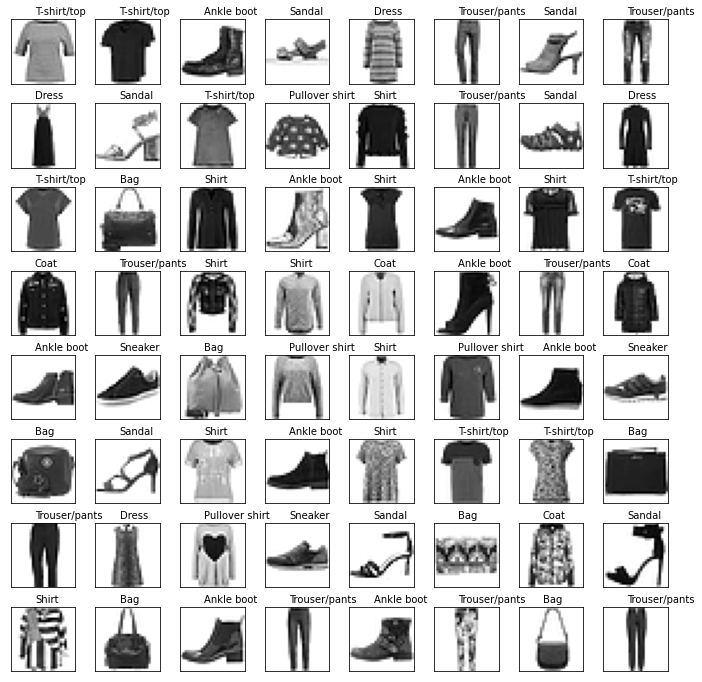

In [25]:
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

def display_batch_64(test_batch, test_labels):
    n_rows, n_cols = 8, 8
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for n, (image, label) in enumerate(zip(test_batch, test_labels)):
        row = n // n_cols
        col = n % n_cols
        axes[row, col].imshow(image[:,:,0], cmap='binary')
        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].get_yaxis().set_visible(False)
        axes[row, col].text(10., -2.5, f'{class_names[label]}')
    plt.show()

display_batch_64(test_batch, test_labels)

## Finding a NaN output with tensorflow functions (not model)

In [12]:
from modules.models import Backbone, OutputLayer, NormHead, ArcHead 

# Config
input_size=28
channels=1
num_classes=10
name='arcface_model'
margin=0.5
logist_scale=64
embd_shape=2
head_type='ArcHead'
backbone_type='Custom'
use_pretrain=False
training=True
batch_size = 64

# Model functions
backbone = Backbone(backbone_type=backbone_type, use_pretrain=use_pretrain)
output_layer = OutputLayer(embd_shape)
archead = ArcHead(num_classes=num_classes, margin=margin, logist_scale=logist_scale)
normhead = NormHead(num_classes=num_classes)

# Loss function
loss_fn = SoftmaxLoss()

In [13]:
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

dataset_length = x_test.shape[0]
batchsize = 64

# Loop to find a k which outputs a NaN
for k in tqdm(range(dataset_length-batchsize-1)):
    # Define test batch
    test_batch = x_test[k:k+batch_size]
    test_labels = y_test[k:k+batch_size]
    test_batch = test_batch[..., np.newaxis]

    # Compute intermediary network values
    x = backbone(test_batch)
    embds = output_layer(x)

    arc_logits = archead(embds, test_labels)
    norm_logits = normhead(embds)

    if (np.isnan(np.mean(x.numpy())) or np.isnan(np.mean(embds.numpy())) or np.isnan(np.mean(arc_logits.numpy())) or np.isnan(np.mean(norm_logits.numpy())) or np.isnan(loss_fn(test_labels, arc_logits)) or np.isnan(loss_fn(test_labels, norm_logits))):
        index = k
        break

k = index

print(f"Batch: {k} -> {k+batch_size-1}")
print(f"mean(x): {np.mean(x.numpy())}")
print(f"mean(embds): {np.mean(embds.numpy())}")
print(f"mean(arc_logits): {np.mean(arc_logits.numpy())}")
print(f"mean(norm_logits): {np.mean(norm_logits.numpy())}")

print(f"Loss arc: {loss_fn(test_labels, arc_logits)}")
print(f"Loss norm: {loss_fn(test_labels, norm_logits)}")

  0%|▎                                                                                              | 27/9935 [00:07<45:28,  3.63it/s]

Batch: 27 -> 90
mean(x): 0.00038145825965330005
mean(embds): 0.14534398913383484
mean(arc_logits): nan
mean(norm_logits): -0.044671107083559036
Loss arc: nan
Loss norm: 2.285533905029297


In [14]:
arc_logits

<tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[-63.349785  ,  -7.5825906 ,  57.03429   ,  33.216198  ,
        -49.72476   ,  29.237114  , -62.158062  , -49.04341   ,
        -17.35071   ,  49.694843  ],
       [-18.179638  ,  31.87528   ,  63.085995  ,  59.314976  ,
        -63.94652   , -10.55499   , -58.957626  , -63.89379   ,
         22.878605  ,  54.839836  ],
       [-53.31187   , -11.151229  ,  55.307648  ,  -0.68418694,
        -47.375507  ,  32.39847   , -61.2004    , -46.648666  ,
        -20.794178  ,  47.34356   ],
       [  7.296489  ,  51.058857  ,  53.83027   ,  63.99044   ,
        -59.865887  , -34.42631   , -44.502438  , -60.23626   ,
         16.937838  ,  59.88266   ],
       [  8.375602  ,  51.707027  ,  53.234425  ,  63.96243   ,
        -59.47282   , -35.337902  , -43.71464   , -59.860214  ,
         17.983885  ,  59.49035   ],
       [-50.6262    ,  -6.5883417 ,  57.481174  ,   3.9217396 ,
        -50.348476  ,  28.343657  , -62.38874   , -49.680134 

Inspecting arc_logits shows that a single NaN appears in the tensor, which then propagates forward to the loss, then (during training) backward to the whole network.

However this experiment is not replicable, even when fixing seeds: try to run the following cell multiple times. It yields different outputs every time, despite the "model" having been already called above and the "k" being the one we found to produce a NaN output:  

In [15]:
# Checking that this is the correct testing batch
np.testing.assert_almost_equal(test_batch, x_test[k:k+batch_size][..., np.newaxis])

# Compute the intermediary tensors on this batch
x = backbone(test_batch)
embds = output_layer(x)
arc_logits = archead(embds, test_labels)
norm_logits = normhead(embds)

print(f"Batch: {k} -> {k+batch_size-1}")
print(f"mean(x): {np.mean(x.numpy())}")
print(f"mean(embds): {np.mean(embds.numpy())}")
print(f"mean(arc_logits): {np.mean(arc_logits.numpy())}")
print(f"mean(norm_logits): {np.mean(norm_logits.numpy())}")

print(f"Loss arc: {loss_fn(test_labels, arc_logits)}")
print(f"Loss norm: {loss_fn(test_labels, norm_logits)}")

Batch: 27 -> 90
mean(x): -0.03654325753450394
mean(embds): -0.10478709638118744
mean(arc_logits): -1.582801342010498
mean(norm_logits): -0.045603394508361816
Loss arc: 77.38868713378906
Loss norm: 2.3130745887756348


I am not sure whether this instability comes from the fact that we are not using a Model object so that the weights are not initialized yet. Let's instead try to use the whole model:

## Finding a NaN output using the whole model

In [16]:
config_arc = load_json_dict("configs/test_arc.json")

model = ArcModel(input_size=config_arc['input_size'],
                    backbone_type=config_arc['backbone_type'],
                    num_classes=config_arc['num_classes'],
                    training=True)

In [17]:
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

dataset_length = x_test.shape[0]
batch_size = 64

# Loop to find a k which outputs a NaN
indexx = None
for j in tqdm(range(dataset_length-batch_size)):
    # Define test batch
    test_batch = x_test[j:j+batch_size]
    test_labels = y_test[j:j+batch_size]
    test_batch = test_batch[..., np.newaxis]

    logits = model((test_batch, test_labels))
    
    if np.isnan(np.mean(logits)):
        indexx = j
        break

if indexx is not None:
    j = indexx
    print(f"Batch: {j} -> {j+batch_size-1}")
    print(f"mean(logits): {np.mean(logits)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9936/9936 [03:50<00:00, 43.05it/s]


Here apparently no NaNs are outputted anymore, let's try to iterate over the Dataset object ... 

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train/255.
x_test = x_test/255.

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

y_train = tf.convert_to_tensor(y_train, tf.float32)
y_train = tf.expand_dims(y_train, axis=1)

y_test = tf.convert_to_tensor(y_test, tf.float32)
y_test = tf.expand_dims(y_test, axis=1)

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), y_train))
train_dataset = train_dataset.batch(batch_size)#prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((x_test, y_test), y_test))
test_dataset = test_dataset.batch(batch_size)#prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
output = None
for step, (inputs, labels) in tqdm(enumerate(train_dataset)):
    with tf.GradientTape() as tape:
        logits = model(inputs, training=True)
        loss = loss_fn(labels, logits)

    if np.isnan(np.mean(logits)) or np.isnan(loss):
        nan_batch, nan_labels = inputs, labels
        output = (nan_batch, nan_labels)

if output is not None:
    (nan_batch, nan_labels) = output
    print(np.isnan(np.mean(model(nan_batch))))

938it [00:29, 32.22it/s]


Doesn't return any NaNs, neither in the test dataset nor the training dataset.

Let's try to train the network but copy-pasting from the problematic script: (this is an exact copy of train2.py)

In [21]:
from tensorflow.keras.optimizers import Adam

from modules.utils import load_json_dict

config="configs/test_arc.json"
config = load_json_dict(config)

model = ArcModel(input_size=config['input_size'],
                        channels=1, 
                        name='Backbone_test',
                        backbone_type=config['backbone_type'],
                        num_classes=config['num_classes'],
                        head_type=config['head_type'],
                        embd_shape=config['embd_shape'],
                        training=True)

learning_rate = tf.constant(config['learning_rate'])
optimizer = Adam(learning_rate=learning_rate)
loss_fn = SoftmaxLoss()

# Manual loop
for epoch in range(config['epochs']):
    print(f"====== Begin epoch {epoch} / {config['epochs']} ======")

    for step, (inputs, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logist = model(inputs, training=True)
            loss = loss_fn(labels, logist)

        #TODO delete this debug
        if step%10==0:
            print(f"Step: {step}, loss: {loss}")  

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print(f"End of epoch {epoch}, saving weights...")
    model.save_weights(ckpt_path+f"/e_{epoch}.ckpt")

print("============ Training done! ============")

====== Begin epoch 0 / 1 ======
Step: 0, loss: 84.42976379394531
Step: 10, loss: 39.33576202392578
Step: 20, loss: 35.71160125732422
Step: 30, loss: 39.84904861450195
Step: 40, loss: 43.33485412597656
Step: 50, loss: 34.97114181518555
Step: 60, loss: 32.63799285888672
Step: 70, loss: 36.248023986816406
Step: 80, loss: 33.124847412109375
Step: 90, loss: 25.567554473876953
Step: 100, loss: 24.29899787902832
Step: 110, loss: 27.020904541015625
Step: 120, loss: nan
Step: 130, loss: nan
Step: 140, loss: nan
Step: 150, loss: nan
Step: 160, loss: nan
Step: 170, loss: nan
Step: 180, loss: nan
Step: 190, loss: nan
Step: 200, loss: nan
Step: 210, loss: nan
Step: 220, loss: nan
Step: 230, loss: nan
Step: 240, loss: nan
Step: 250, loss: nan
Step: 260, loss: nan
Step: 270, loss: nan
Step: 280, loss: nan
Step: 290, loss: nan
Step: 300, loss: nan
Step: 310, loss: nan
Step: 320, loss: nan
Step: 330, loss: nan
Step: 340, loss: nan
Step: 350, loss: nan
Step: 360, loss: nan
Step: 370, loss: nan
Step: 380

NameError: name 'ckpt_path' is not defined

And sure enough, it yields nans. Let's try to isolate a minimal replicable bug:

In [22]:
from tensorflow.keras.optimizers import Adam

from modules.utils import load_json_dict

config="configs/test_arc.json"
config = load_json_dict(config)

model = ArcModel(input_size=config['input_size'],
                        channels=1, 
                        name='Backbone_test',
                        backbone_type=config['backbone_type'],
                        num_classes=config['num_classes'],
                        head_type=config['head_type'],
                        embd_shape=config['embd_shape'],
                        training=True)

# Model weight history
weight_dict = {}
for variable in model.trainable_variables:
    weight_dict[variable.name] = [np.mean(np.abs(variable.read_value()))]
loss_history = []


learning_rate = tf.constant(config['learning_rate'])
optimizer = Adam(learning_rate=learning_rate)
loss_fn = SoftmaxLoss()

# Manual loop
for step, (inputs, labels) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
        logist = model(inputs, training=True)
        loss = loss_fn(labels, logist)

    if np.isnan(np.mean(logits)) or np.isnan(loss):
        save_batch = inputs  
        break
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Update model weight history
    for variable in model.trainable_variables:
        weight_dict[variable.name].append(np.mean(np.abs(variable.read_value())))
    loss_history.append(loss.numpy())


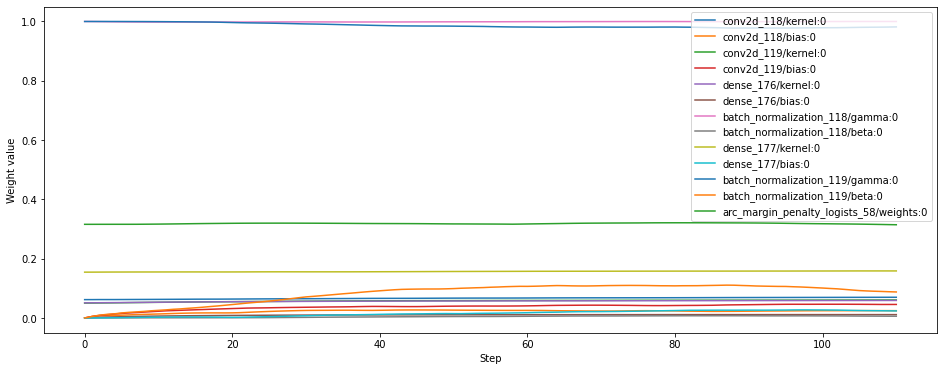

In [23]:
# Plot the evolution of the variables
plt.figure(figsize=(16,6))
for variable_name in weight_dict:
    value_list = weight_dict[variable_name]
    plt.plot(value_list, label=variable_name)
plt.xlabel("Step")
plt.ylabel("Weight value")
plt.legend()
plt.show()

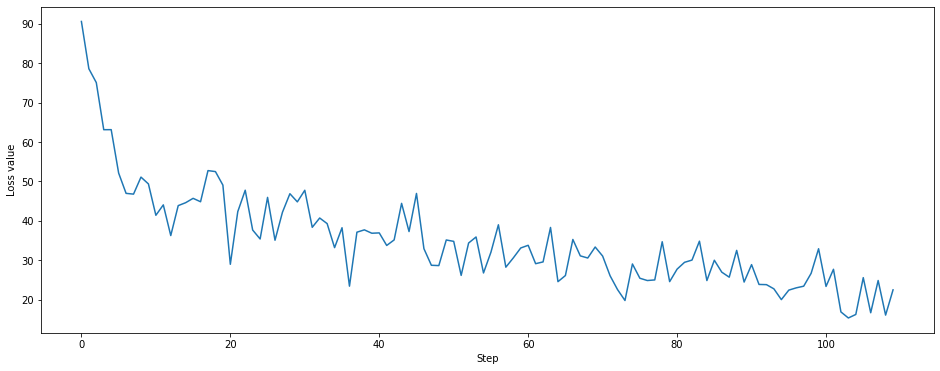

In [24]:
plt.figure(figsize=(16,6))
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()

# (FOR LATER) Loading a model and computing the embeddings

In [2]:
# Load test dataset

batch_size=64
shuffle=True
buffer_size=1000


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = x_test/255.

In [9]:
# Load config

config = load_json_dict("configs/test_norm.json")
# config = load_json_dict("configs/test_arc.json")
config

{'input_size': 28,
 'epochs': 1,
 'learning_rate': 0.005,
 'batch_size': 64,
 'num_classes': 10,
 'embd_shape': 2,
 'backbone_type': 'Custom',
 'head_type': 'NormHead',
 'ckpt_name': 'test_norm'}

In [11]:
model = ArcModel(input_size=config['input_size'],
                    backbone_type=config['backbone_type'],
                    training=False)

In [12]:
# Compute embeddings before training

embeddings_before = model(x_test).numpy()

In [13]:
# Load model weights

ckpt_path = tf.train.latest_checkpoint('./checkpoints/' + config['ckpt_name'])
if ckpt_path is not None:
    model.load_weights(ckpt_path)


In [15]:
embeddings = model(x_test).numpy()

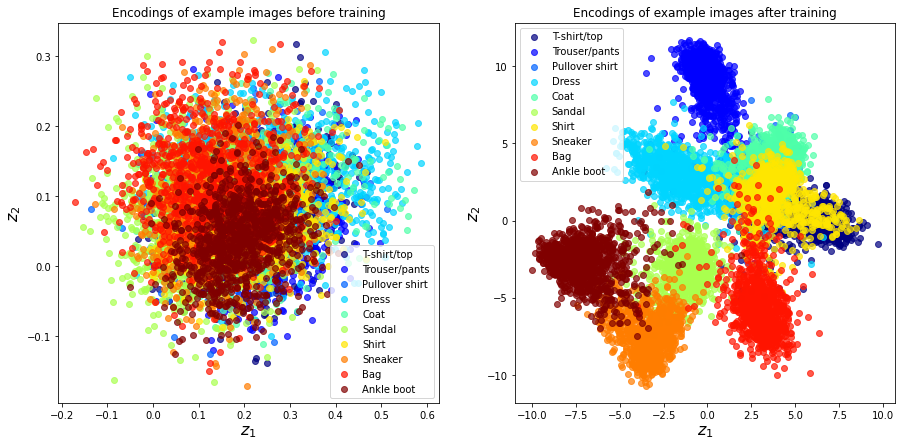

In [16]:
# Plot untrained and trained encodings

class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

plt.subplot(1, 2, 1)
for i, class_label in enumerate(class_names):
    inx = np.where(y_test == i)[0]
    plt.scatter(embeddings_before[inx, 0], embeddings_before[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()

plt.subplot(1, 2, 2)
for i, class_label in enumerate(class_names):
    inx = np.where(y_test == i)[0]
    plt.scatter(embeddings[inx, 0], embeddings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images after training')
plt.legend()

plt.show()